<a href="https://colab.research.google.com/github/project-mlx/mlx-projects-case-studies/blob/main/image_to_image_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image to Image Translation
###using Generative Adversarial Networks

The image-to-image translation is a process of taking images of one type (satellite images in this case) as inputs and reconstructing them like the images of another type (maps in this case). The characteristics of the images get rearranged for them to look like the images we need them to look like.

**Genera Approach**
- Collect and preprocess satellite to map image translation dataset (http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz)
- Develop and train Conditional Generative Adverasarial Network model on the dataset - WIP
- Evaluate the model - WIP

In [22]:
from os import listdir

from numpy import asarray
from numpy import vstack
from numpy import savez_compressed
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

from matplotlib import pyplot

##Preprocessing
Function for resizing, splitting, and converting images to array of pixels.

In [11]:
def import_images(source, size=(256,512)):
  input_list, output_list = list(), list()
  
  for imagename in listdir(source):
    # resizing and converting to array of pixels
    image = load_img(source + imagename, target_size=size)
    px = img_to_array(image)
    # splitting into satellite and map, two separate images
    satellite_img, map_img = px[:, :size[0]], px[:, size[0]:]
    input_list.append(satellite_img)
    output_list.append(map_img)
    
  return [asarray(input_list), asarray(output_list)]

Save the preprocessed image pairs with savez_compressed


In [15]:
source = '/content/drive/MyDrive/Datasets/maps/train/'

[input_images, output_images] = import_images(source)
print('Loaded: ', input_images.shape, output_images.shape)
filename = '/content/df_256.npz'
savez_compressed(filename, input_images, output_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  df_256.npz


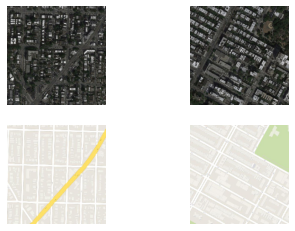

In [21]:
images = load('df_256.npz')
input_images, output_images = images['arr_0'], images['arr_1']
# plot input images
n = 2
for i in range(n):
	pyplot.subplot(2, n, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(input_images[i].astype('uint8'))

# plot output image
for i in range(n):
	pyplot.subplot(2, n, 1 + n + i)
	pyplot.axis('off')
	pyplot.imshow(output_images[i].astype('uint8'))
pyplot.show()

##Developing the GAN model
**Creating the discriminator model**
- initializing random weight
- creating a compatible input for discriminator
- creating the convolutional classification network
- generating the sigmoid output

In [74]:
def discriminator(shape):
  initial_weight = RandomNormal(stddev=0.02)
  input_image = Input(shape=shape)
  output_image = Input(shape=shape)

  #input layer
  disc_input = Concatenate()([input_image, output_image])
  disc = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weight)(disc_input)
  disc = LeakyReLU(alpha=0.2)(disc)

  disc = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weight)(disc)
  disc = BatchNormalization()(disc)
  disc = LeakyReLU(alpha=0.2)(disc)

  disc = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weight)(disc)
  disc = BatchNormalization()(disc)
  disc = LeakyReLU(alpha=0.2)(disc)

  disc = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weight)(disc)
  disc = BatchNormalization()(disc)
  disc = LeakyReLU(alpha=0.2)(disc)

  # pre-output layer without strides (steps of the receptive field)
  disc = Conv2D(512, (4,4), padding='same', kernel_initializer=initial_weight)(disc)
  disc = BatchNormalization()(disc)
  disc = LeakyReLU(alpha=0.2)(disc)

  # sigmoid patch output
  disc = Conv2D(1, (4,4), padding='same', kernel_initializer=initial_weight)(disc)
  output_patch = Activation('sigmoid')(disc)

  model = Model([input_image, output_image], output_patch)

  optimizer = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, loss_weights=[0.5])

  return model

**Creating the generator model**
- creating an encoder
- creating a decoder
- creating the generator model function

Encoder

In [82]:
def encoder(input_layer, filters, normalize=True):
	initial_weight = RandomNormal(stddev=0.02)
	downsample = Conv2D(filters, (4,4),
                     strides=(2,2), padding='same',
                     kernel_initializer=initial_weight)(input_layer)
	if normalize:
		downsample = BatchNormalization()(downsample, training=True)
	downsample = LeakyReLU(alpha=0.2)(downsample)
	return downsample

Decoder

In [83]:
def decoder(input_layer, skip, filters, dropout=True):
	initial_weight = RandomNormal(stddev=0.02)
	upsample = Conv2DTranspose(filters, (4,4),
                            strides=(2,2), padding='same',
                            kernel_initializer=initial_weight)(input_layer)
	upsample = BatchNormalization()(upsample, training=True)
	if dropout:
		upsample = Dropout(0.5)(upsample, training=True)
	upsample = Concatenate()([upsample, skip])
	upsample = Activation('relu')(upsample)
	return upsample

Generator

In [84]:
def generator(shape=(256,256,3)):
  initial_weight = RandomNormal(stddev=0.02)
  input_image = Input(shape=shape)
  
  # encoding
  encoding1 = encoder(input_image, 64, normalize=False)
  encoding2 = encoder(encoding1, 128)
  encoding3 = encoder(encoding2, 256)
  encoding4 = encoder(encoding3, 512)
  encoding5 = encoder(encoding4, 512)
  encoding6 = encoder(encoding5, 512)
  encoding7 = encoder(encoding6, 512)
  bottleneck = Conv2D(512, (4,4), strides=(2,2), padding='same',kernel_initializer=initial_weight)(encoding7)
  bottleneck = Activation('relu')(bottleneck)

  # decoding
  decoding1 = decoder(bottleneck, encoding7, 512)
  decoding2 = decoder(decoding1, encoding6, 512)
  decoding3 = decoder(decoding2, encoding5, 512)
  decoding4 = decoder(decoding3, encoding4, 512, dropout=False)
  decoding5 = decoder(decoding4, encoding3, 256, dropout=False)
  decoding6 = decoder(decoding5, encoding2, 128, dropout=False)
  decoding7 = decoder(decoding6, encoding1, 64, dropout=False)

  # output
  out_layer = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weight)(decoding7)
  output_image = Activation('tanh')(out_layer)

  model = Model(input_image, output_image)
  return model

Creating the GAN function that train the whole network

In [85]:
def gan(generator, discriminator, shape):
	# making weights in the discriminator not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False

	input = Input(shape=image_shape)
	generator_output = generator(input)
	discriminator_output = discriminator([input, generator_output])
	model = Model(input, [discriminator_output, generator_output])
 
	optimizer = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, loss_weights=[1,100])
	return model


Loading training samples

In [86]:
def training_samples(filename):
	data = load(filename)
	input_image, output_image = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	input_image = (input_image - 127.5) / 127.5
	output_image = (output_image - 127.5) / 127.5
	return [input_image, output_image]

Extracting real samples

In [87]:
def generate_real_samples(df, n_samples, patch_shape):
	train_a, train_b = df
  # randomly select images
	rand_imgs = randint(0, train_a.shape[0], n_samples)
	# extract selected images
	input_image, output_image = train_a[rand_imgs], train_b[rand_imgs]
	output = ones((n_samples, patch_shape, patch_shape, 1))
	return [input_image, output_image], output

Generating fake samples

In [88]:
def generate_fake_samples(generator, samples, patch_shape):
	generated_img = generator.predict(samples)
	#creating 'fake' class labels(0)
	class_label = zeros((len(generated_img), patch_shape, patch_shape, 1))
	return generated_img, class_label

Function to save the model and generate samples and save as plots, at the intervals of 10 epochs.


In [89]:
def performance_summary(step, generator, dataset, n_samples=3):
	[real_input_img, real_output_img], _ = generate_real_samples(dataset, n_samples, 1)
	fake_output_img, _ = generate_fake_samples(generator, real_input_img, 1)
	
  # scale all pixels from [-1,1] to [0,1]
	real_input_img = (real_input_img + 1) / 2.0
	real_output_img = (real_output_img + 1) / 2.0
	fake_output_img = (fake_output_img + 1) / 2.0

	# plotting real input images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(real_input_img[i])
  
	# plotting generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(real_output_img[i])
  
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(real_output_img[i])
  
	# save plot to file
	plotfile = '/content/models/plot_%06d.png' % (step+1)
	pyplot.savefig(plotfile)
	pyplot.close()
 
	# save the generator model
	modelfile = '/content/models/model_%06d.h5' % (step+1)
	generator.save(modelfile)
	print('>Saved: %s and %s' % (plotfile, modelfile))

Training function

In [90]:
def train(discriminator, generator, GAN, df, epochs=100, batch=1):
  patch = discriminator.output_shape[1]
  train_input_imgs, train_output_imgs = df
  batch_per_epoch = int(len(train_input_imgs) / batch)
  steps = batch_per_epoch * epochs
  for i in range(steps):
   [real_input_img, real_output_img], output_real = generate_real_samples(df, batch, patch)
   # generating a batch of fake samples
   fake_output_img, output_fake = generate_fake_samples(generator, real_input_img, patch)
   # updating discriminator for real samples
   disc_loss_1 = discriminator.train_on_batch([real_input_img, real_output_img], output_real)
   # updating discriminator for generated samples
   disc_loss_2 = discriminator.train_on_batch([real_input_img, fake_output_img], output_fake)
   # updating the generator
   gen_loss, _, _ = GAN.train_on_batch(real_input_img, [output_real, real_output_img])
   # summarizing performance
   print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, disc_loss_1, disc_loss_2, gen_loss))
   # summarizing model performance
   if (i+1) % (batch_per_epoch * 10) == 0:
     performance_summary(i, generator, df)

Train GAN model

In [91]:
df = training_samples('df_256.npz')
image_shape = df[0].shape[1:]
image_shape

(256, 256, 3)

In [ ]:
discriminator = discriminator(image_shape)
generator = generator(image_shape)

GAN = gan(generator, discriminator, image_shape)

# training
train(discriminator, generator, GAN, df)